# Importing Important Libraries

In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import StandardScaler # Mean 0 and Std 1 (Scales all the data in the same range), 1 Feature very big, others very small
from sklearn.decomposition import PCA #For dimensionality reduction
from sklearn.metrics import mean_squared_error # To find the error between predicted and actual values
import tensorflow as tf # For deep learning, we will use TensorFlow..
from tensorflow.keras.models import Sequential # For building the model, in a layered fashio
from tensorflow.keras.layers import LSTM, Dense, Dropout # For processing time series data, 
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Function to compute technical indicators (To get the proper insights on the trend)


In [5]:
def compute_technical_indicators(df):
    df['SMA_10'] = df['Close'].rolling(window=10).mean() # Simple Moving Average 
    df['SMA_30'] = df['Close'].rolling(window=30).mean() 
    df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean() # Exponential Moving Average
    df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean() #Is gives priorities to recent prices. (Less lag than SMA)
    delta = df['Close'].diff() # Difference between today's and yesterday's close price
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean() # Gain is the average of positive changes by delta 
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean() #
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df['MACD'] = df['EMA_12'] - df['EMA_26'] # Moving average convergance divergance (Price difference in long and short term price)
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean() #Down to Up --> Bullish, and VV
    df['BB_Middle'] = df['Close'].rolling(window=20).mean() # Bollinger Bands Middle Line (20-day SMA) Trend Indentification
    df['BB_Std'] = df['Close'].rolling(window=20).std()
    df['BB_Upper'] = df['BB_Middle'] + 2 * df['BB_Std']
    df['BB_Lower'] = df['BB_Middle'] - 2 * df['BB_Std']
    return df

'''
BB Uppper
BB Middle
BB Lower (Middle to Lower --> Over Sold, Middle to Upper --> Over Bought)
'''

'\nBB Uppper\nBB Middle\nBB Lower (Middle to Lower --> Over Sold, Middle to Upper --> Over Bought)\n'

# Function to prepare data for LSTM


In [6]:
def prepare_lstm_data(X, y, time_steps=60): # Prepare data for Time Series Forecasting 
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

''' 
We divide the data into chunks of 60 days, and the target is the next day price. {Sliding Window}
1-60 --> Predict value of 61st day
2-61 --> Predict value of 62nd day.. 
'''

' \nWe divide the data into chunks of 60 days, and the target is the next day price. {Sliding Window}\n1-60 --> Predict value of 61st day\n2-61 --> Predict value of 62nd day.. \n'

# Function to predict future values


In [7]:
def predict_future(model, last_sequence, scaler_y, future_days, time_steps, n_components):
    future_predictions = []  # Initialize the list to store future predictions
    current_sequence = last_sequence.copy() # last_sequence --> the last 60 days of data, so we have just taken copy of it..

    for _ in range(future_days): # One day at a time
        current_sequence_reshaped = current_sequence.reshape(1, time_steps, -1) # Single Sequence, 60 time steps, and all features (PCA components)
       
        # Predict the next value (scaled)
        next_pred_scaled = model.predict(current_sequence_reshaped, verbose=0) # Predicting the next value based on the current sequence
        # The model outputs a single value (the predicted scaled Close price for the next time step)

        # Inverse transform the prediction to original scale
        next_pred = scaler_y.inverse_transform(next_pred_scaled) # Converts the scaled prediction (next_pred_scaled) back to the original stock price scale using scaler_y.
        future_predictions.append(next_pred[0, 0])

        # Replicate the predicted scaled value across all PCA components to match shape
        next_pred_scaled_replicated = np.repeat(next_pred_scaled, n_components, axis=1)  # Shape: (1, n_components)
        
        # Update the sequence: remove the oldest time step, append the new "PCA" values
        current_sequence = np.vstack((current_sequence[1:], next_pred_scaled_replicated))

    return np.array(future_predictions)

# Step 1: Fetch stock data


In [8]:
ticker = 'TSLA'
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)  # 5 years of data
stock_data = yf.download(ticker, start=start_date, end=end_date)

# Ensure the DataFrame has a flat column structure
if isinstance(stock_data.columns, pd.MultiIndex):
    stock_data.columns = stock_data.columns.get_level_values(0)
print("Columns after fetching data:", stock_data.columns)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Columns after fetching data: Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')


# Step 2: Compute technical indicators


In [9]:
stock_data = compute_technical_indicators(stock_data)

# Step 3: Select features and handle missing values


In [10]:
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'SMA_30', 
            'EMA_12', 'EMA_26', 'RSI', 'MACD', 'MACD_Signal', 
            'BB_Middle', 'BB_Upper', 'BB_Lower']
stock_data = stock_data[features].dropna() # Drop rows with NaN values after computing indicators

# Step 4: Prepare features and target


In [11]:
X = stock_data.drop(columns=['Close']) # Drop the target variable 'Close' from features
y = stock_data['Close'].values # Here we are taking the 'Close' price as the target variable

# So now we have X as the features and y as the target variable

# Step 5: Standardize the features and target


In [12]:
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Scale the target variable (y)
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()


''' 
Features like Open (eg. $100), Volume (eg. 1000), and RSI (eg. 70) have different scales. 
Standardization makes them comparable (eg. values like 0.5, -1.2) so the model doesnt
get confused by large or small numbers.
So here X_scaled is a new array/lift where all features have a MEAN of 0 and a SD of 1.
'''

' \nFeatures like Open (eg. $100), Volume (eg. 1000), and RSI (eg. 70) have different scales. \nStandardization makes them comparable (eg. values like 0.5, -1.2) so the model doesnt\nget confused by large or small numbers.\nSo here X_scaled is a new array/lift where all features have a MEAN of 0 and a SD of 1.\n'

# Step 6: Apply PCA


In [13]:
pca = PCA() # to perform dimensionality reduction
X_pca = pca.fit_transform(X_scaled)

# Select components explaining 85% of variance
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_) # Take data from PCA and find the cumulative explained variance ratio
n_components = np.argmax(explained_variance_ratio >= 0.85) + 1 # Make sure that the cumulative explained variance ratio is greater than or equal to 0.85
                                                               # Means it should take the number of components such that the explained variance is at least 85%
X_pca = X_pca[:, :n_components]

'''
We have learnt in the ppt that PCA reduces the number of features while keeping most of the important information.
So here i am performing dimensionality reduction using PCA, and then preparing the data for LSTM.
Open, Vol, CLose, etc. are now transformed into PCA components (Directions), which are then used as features for the LSTM model.
'''

'\nWe have learnt in the ppt that PCA reduces the number of features while keeping most of the important information.\nSo here i am performing dimensionality reduction using PCA, and then preparing the data for LSTM.\nOpen, Vol, CLose, etc. are now transformed into PCA components (Directions), which are then used as features for the LSTM model.\n'

# Step 7: Prepare data for LSTM


In [14]:
time_steps = 60
X_lstm, y_lstm = prepare_lstm_data(X_pca, y_scaled, time_steps)



# Step 8: Split data into train and test sets


In [15]:
train_size = int(0.8 * len(X_lstm))
X_train, X_test = X_lstm[:train_size], X_lstm[train_size:] # Training and Testing data split
y_train, y_test = y_lstm[:train_size], y_lstm[train_size:]

# Why only 80%? 
# Because we want to test the model on the remaining 20% of the data to see how well it generalizes.


# Step 9: Build LSTM model


In [ ]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_steps, n_components)), # This layer processes the time series data, 50 units/helpers..
    Dropout(0.2), # randomly turning off 20% of the units during training.. so that the model does not overfit to the training data
    LSTM(50), # another LSTM layer to capture more complex patterns
    Dropout(0.2), # another dropout layer to prevent overfitting
    Dense(25), # 25 smart helpers r the team lookign for patterns in the data, so it is creating 25 key insights
    Dense(1) # Final boss, summarise 25 key insights into a single prediction (the next day's stock price)
    # Like here's my best guess for the next day's stock price based on the patterns I have learned from the past 60 days of data.
])

model.compile(optimizer='adam', loss='mse')

# adam --> Adaptive Moment Estimation, a popular optimizer for training deep learning models
# it is helping my model to learn the patterns in the data and minimize the loss function (MSE in this case)..
# MSE --> Measn Squared Error, Low MSE means the model is performing well

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Step 10: Train the model with more epochs


In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, 
                    validation_split=0.1, verbose=1)

'''
100 epochs means the model will go through the entire training data 100 times.. (Like practicing the song 100 times)
# Batch size --> TSLA data in 32 chunks.. (Studying 32 pages of a book at a time to learn faster
# Validation split --> 10% of the training data will be used for validation to check how well the model is learning)
'''

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.3241 - val_loss: 0.0209
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.1065 - val_loss: 0.0255
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0753 - val_loss: 0.0349
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0775 - val_loss: 0.0358
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0743 - val_loss: 0.0220
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0648 - val_loss: 0.0203
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0621 - val_loss: 0.0295
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0522 - val_loss: 0.0225
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0545 - val_loss: 0.0181
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0540 - val_loss: 0.0179
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0515 - val_loss: 0.0214
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step

# Step 11: Make predictions on test data


In [ ]:
y_pred_scaled = model.predict(X_test)

# Inverse transform the predictions and actual values
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

'''
Here I am using the trained model to predict the stock prices for the test data (the 20% of the data that was not used for training).
'''

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


# Step 12: Evaluate the model


In [19]:
mse = mean_squared_error(y_test_actual, y_pred)
print(f'Mean Squared Error on Test Data: {mse:.2f}')

Mean Squared Error on Test Data: 300.70


# Step 13: Predict future values (e.g., 30 days into the future)


In [ ]:
future_days = 30
last_sequence = X_lstm[-1]  # Last sequence from the test data
future_predictions = predict_future(model, last_sequence, scaler_y, future_days, time_steps, n_components)

'''

'''

# Step 14: Prepare data for plotting


In [ ]:
test_length = len(y_test_actual) # Create an array for future x values
future_x = np.arange(test_length, test_length + future_days)

# Now here I am combining the predictions and future predictions for plotting

# Flatten y_pred to 1D since it's (n_samples, 1)
y_pred_flat = y_pred.flatten()
# Ensure future_predictions is 1D (it already is, but for clarity)
future_predictions = future_predictions.flatten()
# Concatenate the 1D arrays
combined_predictions = np.concatenate([y_pred_flat, future_predictions])

# Step 15: Plot results with future predictions


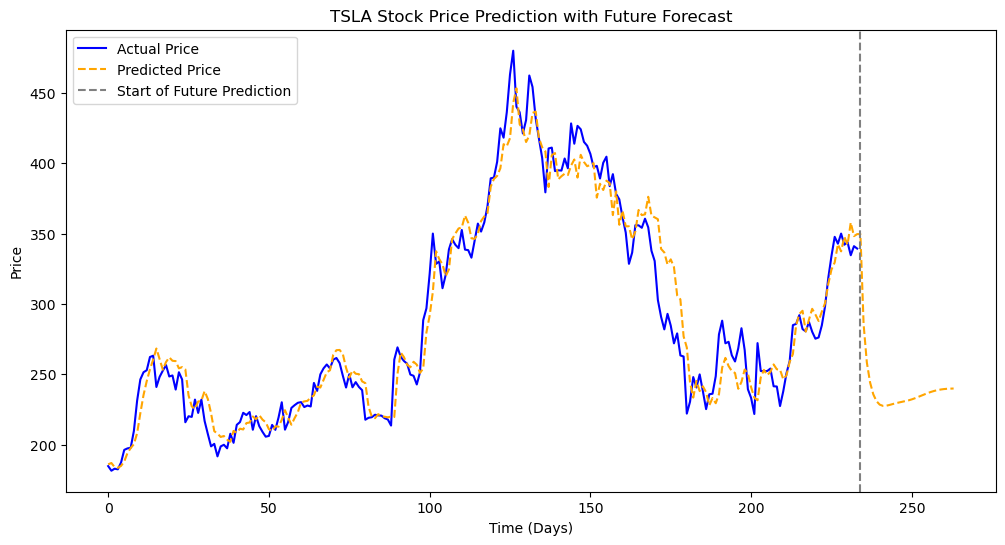

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(test_length), y_test_actual, label='Actual Price', color='blue')
plt.plot(np.arange(test_length + future_days), combined_predictions, label='Predicted Price', color='orange', linestyle='--')
plt.axvline(x=test_length, color='gray', linestyle='--', label='Start of Future Prediction')
plt.title(f'{ticker} Stock Price Prediction with Future Forecast')
plt.xlabel('Time (Days)')
plt.ylabel('Price')
plt.legend()
plt.savefig('results/tsla_stock_price_prediction_with_future.png')  # Updated pathplt.close()

# Step 16: Plot explained variance ratio


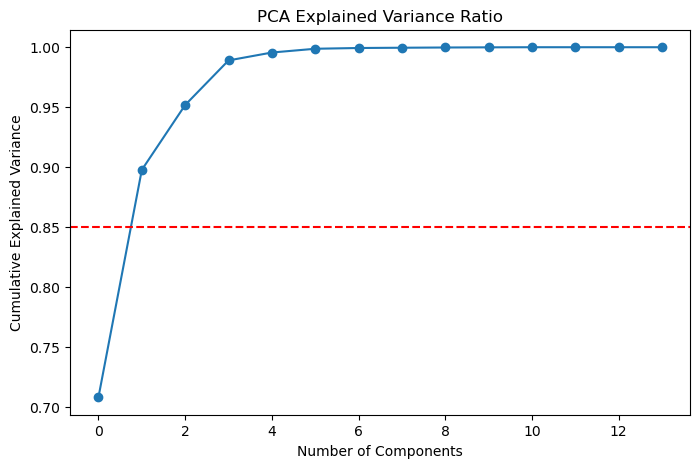

In [23]:
plt.figure(figsize=(8, 5))
plt.plot(explained_variance_ratio, marker='o')
plt.axhline(y=0.85, color='r', linestyle='--')
plt.title('PCA Explained Variance Ratio')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.savefig('results/tsla_pca_variance.png')  # Updated pathplt.close()